# HW4 Levenberg-Marquardt Algorithm

Original jupyter notebook is uploaded at [GitHub](https://github.com/zhuo34/csmath2022). ([参考资料](http://www.voycn.com/article/feixianxingzuixiaoerchengwentiyulevenberg-marquardtsuanfaxiangjie))

LM 算法是一种介于牛顿法和梯度下降法的二阶优化方法。
$$
\min F(\mathbf{x})
$$
在 $x_k$ 处二次泰勒展开为
$$
F(\mathbf{x}_k+\mathbf{s}) \approx q^{(k)}(\mathbf{s})=F(\mathbf{x}_k) + \nabla F(\mathbf{x}_k)^T\mathbf{s} + \frac{1}{2}\mathbf{s}^T\nabla^2F(\mathbf{x}_k)\mathbf{s}
$$
其中 $\mathbf{s}=\mathbf{x}-\mathbf{x_k}$，令 $q^{(k)}(\mathbf{s})$ 最小，即求其导数零点得
$$
\mathbf{x}_{k+1} = \mathbf{x}_k - [\nabla^2F(\mathbf{x}_k)]^{-1}\nabla F(\mathbf{x}_k) = \mathbf{x}_k - G_k^{-1}g_k
$$
由于黑塞矩阵 $G_k$ 不能保证始终正定，因此LM增加了一个正则项 $\mu>0$，称为阻尼系数。
$$
q^{(k)}(\mathbf{s})=F(\mathbf{x}_k) + g_k^T\mathbf{s} + \frac{1}{2}\mathbf{s}^TG_k\mathbf{s} + \frac{1}{2}\mu\mathbf{s}^T\mathbf{s}
$$
对 $\mathbf{s}$ 求导得到
$$
\begin{aligned}
\mathbf{s} &= - (G_k+\mu I)^{-1}g_k \\
\mathbf{x}_{k+1} &= \mathbf{x}_k - (G_k+\mu I)^{-1}g_k
\end{aligned}
$$
可以看到 $\mu$ 在保证正定时，还有如下性质，当 $\mu \rightarrow 0$，即为牛顿法；当 $\mu \rightarrow \infin$，即为梯度下降法。

$\mu$ 的选取
$$
\mu_0 =\tau\max\{(G_k)_{ii}\}
$$
初始值的选取源于 Rayleigh 商，其最大值和最小值分别等于矩阵最大和最小的特征值。如果我们可以确定初始点 $\mathbf{x}_0$ 是在极值点附近，那么 $\mu_0$ 应该相对比较小，那么搜索方式就更加偏向于高斯-牛顿法，$\tau$ 相应取小；如果初始点 $\mathbf{x}_0$ 离极值点可能比较远，那么那么 $\mu_0$ 应该大一些，那么搜索方式就更加偏向于梯度下降法，$\tau$ 相应取大。

确定初始 后，接下来是要确定 的更新规则。根据前面的内容，我们知道的存在是为了保证 在一定邻域内的线性近似程度，可以定义线性近似的程度为
$$
r_k = \frac{F(\mathbf{x})_k - F(\mathbf{x}_k+\mathbf{s}_k)}{q^{(k)}(0) - q^{(k)}(\mathbf{s}_k)}
$$
其中分母可证恒大于零，因此如果 $r_k<0$，即 $F(\mathbf{x}_k+\mathbf{s}_k)$ 不降反升，那我们可以十分肯定 $F(\mathbf{x})$ 的线性近似是有问题的，或者说搜索的邻域太大，那么这时我们不应该更新 $\mathbf{x}$，同时应该增大 $\mu$ 值，以缩小搜索的邻域；当 $r_k$ 是一个比较大的正数，最好是接近1，那么这时我们就可以认为在该邻域内长对的线性近似是比较恰当的，那么我们有理由认为更新 $\mathbf{x}$ 后下一次搜索的邻域可以再扩大些，因此这时候可以适当减小 $\mu$ 值：当 $r_k>0$ 但是又比较小，虽然更新后的 $\mathbf{x}$ 可以使得函数值下降，但下降的幅度度远小于我们的预期，这时我们应该适当缩小下次搜索的邻域，因此这时候可以适当增大 $\mu$ 值。
$$
\begin{aligned}
\mu_{k+1} = \beta\mu_k,\ \text{if}\ r_k < r_1 \\
\mu_{k+1} = \mu_k/\gamma,\ \text{if}\ r_k > r_2 \\
\mathbf{x}_{k+1} = \mathbf{x}_{k} + \mathbf{s}_k,\ \text{if}\ r_k > 0 \\
\end{aligned}
$$
其中 $0 < r_1 < r_2 < 1$，且 $\beta,\gamma >1$，实验表明 LM 算法对参数不敏感。这里设置
$$
r_1 = 0.25, r_2 = 0.75, \beta=4, \gamma=2
$$


minima of `f(x, y) = x^2 + y^2` is (0, 0)
LM results [-4.92425998e-10 -4.92425998e-10] with 49 steps


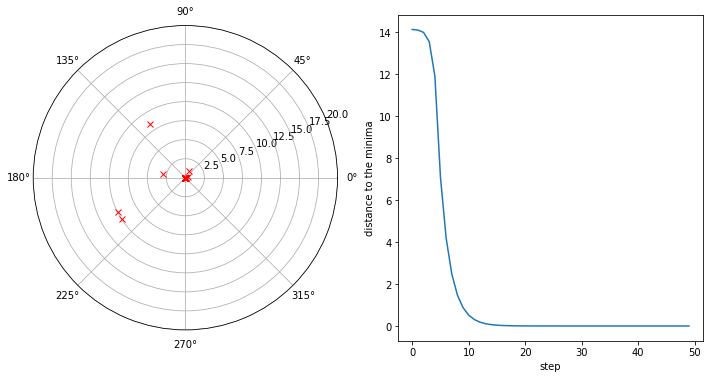

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lu_factor, lu_solve


def gd(gf, x0, alpha=0.01, max_step=1000, epsilon=1e-9):
    x = x0
    step = 0
    while step < max_step:
        g = gf(x) # [n, 1]
        if np.max(np.abs(g)) < epsilon:
            break
        x = x - alpha * g
        step += 1
    return x


def lm(f, gf, Gf, x0, tau=1e-3, max_step=1000, epsilon=1e-9, output_all=False):
    x = x0
    step = 0
    n = len(x)
    I = np.eye(n)
    outputs = {"x": [], "g": [], "G": [], "s": [], "r": [], "u": []}
    outputs["x"].append(x)
    while step < max_step:
        g = gf(x) # [n, 1]
        G = Gf(x) # [n, n]
        if step == 0:
            u = tau * np.max(np.diag(G))

        if np.max(np.abs(g)) < epsilon:
            break

        while not np.all(np.linalg.eigvals(G + u * I) > 0):
            # print("change u", u)
            u *= 4
        old_u = u
        s = lu_solve(lu_factor(G + u * I), -g) # [n, ]
        if np.max(np.abs(s)) < epsilon:
            break
        # s = -np.linalg.inv(G + u * I) @ g
        x_new = x + s
        df = f(x) - f(x_new)
        dq = -g.T @ s - 0.5 * s.T @ G @ s
        r = df / dq
        if r < 0.25:
            u *= 4
        elif r > 0.75:
            u /= 2
        if r > 0:
            x = x_new

        step += 1
        outputs["x"].append(x)
        outputs["g"].append(g.T)
        outputs["G"].append(G)
        outputs["s"].append(s)
        outputs["r"].append(r)
        outputs["u"].append(old_u)
    if not output_all:
        return x
    outputs["step"] = step
    outputs["x"] = np.array(outputs["x"])
    outputs["g"] = np.array(outputs["g"])
    outputs["G"] = np.array(outputs["G"])
    outputs["s"] = np.array(outputs["s"])
    outputs["r"] = np.array(outputs["r"])
    outputs["u"] = np.array(outputs["u"])
    return x, outputs

f = lambda x: x[0] ** 2 + x[1] ** 2
gf = lambda x: 2 * x.T
Gf = lambda x: np.eye(2)

x0 = np.array([10, 10])
x, outputs = lm(f, gf, Gf, x0, max_step=50, output_all=True)

print("minima of `f(x, y) = x^2 + y^2` is (0, 0)")
print(f"LM results {x} with {outputs['step']} steps")
plt.subplots(1, 2, figsize=(12, 6))
ax = plt.subplot(121, projection="polar")
ax.set_rlim(0, 20)
ax.plot(outputs["x"][:, 0], outputs["x"][:, 1], "rx-")
ax = plt.subplot(122)
ax.plot(np.arange(outputs["step"]+1), np.sqrt(np.sum(outputs["x"] ** 2, axis=1)))
ax.set_ylabel("distance to the minima")
ax.set_xlabel("step")
plt.show()


LM 算法可用于求解非线性最小二乘问题。
$$
F = \frac{1}{2}\mathbf{f}^T\mathbf{f}
$$
其中 $\mathbf{f}=g(x;t)-y$ 是误差函数，$t$ 为数据点，$x$ 表示参数, 将 $F$ 一阶泰勒展开
$$
\mathbf{f}(\mathbf{x}+\mathbf{s}) \approx \mathbf{f}(\mathbf{x}) + \mathbf{J}_f(\mathbf{x})\mathbf{s}
$$
其中 $\mathbf{J}_f$ 是雅可比矩阵，$j_{m,n} = \frac{\partial f_m(\mathbf{x})}{\partial x_n}$，$m$ 为数据点个数，$n$ 为参数个数，并带入LM算法
$$
F=\frac{1}{2}\mathbf{f}(\mathbf{x}+\mathbf{s})^T\mathbf{f}(\mathbf{x}+\mathbf{s}) \approx L_{gn}(\mathbf{s}) = \frac{1}{2}\mathbf{f}^T\mathbf{f} + \mathbf{f}^T\mathbf{J}_f\mathbf{s} + \frac{1}{2}\mathbf{s}^T\mathbf{J}_f^T\mathbf{J}_f\mathbf{s}
$$
即
$$
\begin{aligned}
g_k &= \mathbf{J}_f^T\mathbf{f} \\
G_k &= \mathbf{J}_f^T\mathbf{J}_f
\end{aligned}
$$
其余与 LM 算法上述推导相同。

In [2]:
def least_squre_LM(f, J, X, Y, p0, tau=1e-6, max_step=1000, epsilon=1e-9, output_all=False):
    F = lambda p: 0.5 * (f(X, p) - Y) @ (f(X, p) - Y).T
    gF = lambda p: J(X, p).T @ (f(X, p) - Y).T
    GF = lambda p: J(X, p).T @ J(X, p)
    return lm(F, gF, GF, p0, tau=tau, max_step=max_step, epsilon=epsilon, output_all=output_all)

# f: exp(a*x^2 + b*x + c)
np.random.seed(0)
p = np.array([1, 2, 3])
f = lambda x, p: np.exp(p[0] * (x**2) + p[1] * x + p[2])
M = 100
X = np.linspace(0, 1, M)
Y = [f(x, p) + np.random.normal(0, 1) for x in X]

def J(X, p):
    m, n = len(X), len(p)
    J = np.zeros([m, n])
    f_value = np.exp(p[0] * (X**2) + p[1] * X + p[2])
    J[:, 0] = (X ** 2) * f_value
    J[:, 1] = X * f_value
    J[:, 2] = 1 * f_value
    # print("Jf", J)
    return J

p0 = np.array([1, 1, 1])
p1 = least_squre_LM(f, J, X, Y, p0, max_step=200)
print("real", p)
print("LM results", p1)

real [1 2 3]
LM results [1.04313737 1.94480705 3.01523501]
